In [44]:
import os
import pandas as pd
import sys
sys.path.insert(0, '/home/jupyter/')
from hourly_pollution_prediction.process_and_join.bbox import * 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#for image inpainting
from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
import cv2 as cv
import xesmf as xe
import geopandas as gpd
import rioxarray
from rioxarray.merge import merge_arrays
from pathlib import Path

In [1]:
################################################################################
##  Gridded Census Data
################################################################################

# df = pd.read_parquet('../../data/gridded_census_data/gridded_eif_pop_ageracesex_2024.parquet')
# df = df[df['grid_lat'].astype(float)>=lat_min]
# df = df[df['grid_lat'].astype(float)<=lat_max]
# df = df[df['grid_lon'].astype(float)>=lon_min]
# df = df[df['grid_lon'].astype(float)<=lon_max]

# df['grid_lon']=df['grid_lon'].astype(float)
# df['grid_lat']=df['grid_lat'].astype(float)

# df = df.groupby(['grid_lon','grid_lat','race_ethnicity'])['n_noise'].sum().reset_index()

# # Step 2: Pivot to get 3D shape (lat, lon, race)
# df = df.pivot_table(
#     index=["grid_lat", "grid_lon"],
#     columns="race_ethnicity",
#     values="n_noise",
#     aggfunc="mean"  # or "sum" or "first" depending on how you want to handle duplicates
# )

# # Step 3: Convert to xarray
# ds = df.to_xarray()
# ds = ds.rename({var: var.replace("/", "_") for var in ds.data_vars})
# ds.to_netcdf('../../data/gridded_census_data/ds_race.nc')

# df2 = pd.read_parquet('../../data/gridded_census_data/gridded_eif_pop_raceincome_2024.parquet')
# df2 = df2[df2['grid_lat'].astype(float)>=lat_min]
# df2 = df2[df2['grid_lat'].astype(float)<=lat_max]
# df2 = df2[df2['grid_lon'].astype(float)>=lon_min]
# df2 = df2[df2['grid_lon'].astype(float)<=lon_max]

# df2['grid_lon']=df2['grid_lon'].astype(float)
# df2['grid_lat']=df2['grid_lat'].astype(float)

# df2 = df2.groupby(['grid_lon','grid_lat','income_decile'])['n_noise'].sum().reset_index()

# # Step 2: Pivot to get 3D shape (lat, lon, race)
# df2 = df2.pivot_table(
#     index=["grid_lat", "grid_lon"],
#     columns="income_decile",
#     values="n_noise",
#     aggfunc="mean"  # or "sum" or "first" depending on how you want to handle duplicates
# )

# # Step 3: Convert to xarray
# ds2 = df2.to_xarray()
# ds2 = ds2.rename({var: str(var) for var in ds2.data_vars})
# ds2.to_netcdf('../../data/gridded_census_data/ds_income.nc')

################################################################################
##  Tropospheric NO2
################################################################################

# # Input and output paths
# path = '../../data/full_month_data'
# output_dir = '../../data/model_data/EPA_sensor_only'
# os.makedirs(output_dir, exist_ok=True)

# # Gather all .nc files
# nc_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.nc')]
# nc_files=nc_files[5:17]
# # List to store datasets
# ds_list = []

# # Loop through files and extract the variable
# for file in sorted(nc_files):
#     ds = xr.open_dataset(file)[["vertical_column_troposphere_tempo"]]
#     ds_list.append(ds)

# # Concatenate along compatible dimensions (auto-detects 'time')
# combined = xr.concat(ds_list, dim="time")
# # Take mean across time
# mean_ds = combined.mean(dim="time", skipna=True)
# mean_ds.to_netcdf('../../data/gridded_census_data/2024_mean_topospheric_no2.nc')



In [25]:
# Load all datasets
no2 = xr.open_dataset('../../data/gridded_census_data/2024_mean_topospheric_no2.nc')
race = xr.open_dataset('../../data/gridded_census_data/ds_race.nc')
income = xr.open_dataset('../../data/gridded_census_data/ds_income.nc')
population = xr.open_dataset('../../data/other/population_density.nc')
race = race.rename({"grid_lat": "lat", "grid_lon": "lon"})
income = income.rename({"grid_lat": "lat", "grid_lon": "lon"})
race = race.sel(
    lat=race.lat <= 33.385,
    lon=race.lon <= -88.315
)

income = income.sel(
    lat=income.lat <= 33.385,
    lon=income.lon <= -88.315
)
race = race.fillna(0)
income = income.fillna(0)


In [69]:
# Clip to LA boundary
shapefile = gpd.read_file("louisiana.geojson")
ca_shapefile = gpd.read_file("cancer_alley_shapefile/cancer_alley_polygon.shp")

no2 = no2.rio.write_crs("EPSG:4326")
race = race.rio.write_crs("EPSG:4326")
income = income.rio.write_crs("EPSG:4326")
population = population.rio.write_crs("EPSG:4326")

# Set spatial dimensions explicitly
no2 = no2.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
race = race.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
income = income.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
population = population.rio.set_spatial_dims(x_dim="lon", y_dim="lat")


# Now you can clip safely
no2_LA = no2.rio.clip(shapefile.geometry, shapefile.crs, drop=True).drop_vars('spatial_ref')
race_LA = race.rio.clip(shapefile.geometry, shapefile.crs, drop=True).drop_vars('spatial_ref')
income_LA = income.rio.clip(shapefile.geometry, shapefile.crs, drop=True).drop_vars('spatial_ref')
population_LA = population.rio.clip(shapefile.geometry, shapefile.crs, drop=True).drop_vars('spatial_ref')

no2_ca = no2.rio.clip(ca_shapefile.geometry, ca_shapefile.crs, drop=True).drop_vars('spatial_ref')
race_ca = race.rio.clip(ca_shapefile.geometry, ca_shapefile.crs, drop=True).drop_vars('spatial_ref')
income_ca = income.rio.clip(ca_shapefile.geometry, ca_shapefile.crs, drop=True).drop_vars('spatial_ref')
population_ca = population.rio.clip(ca_shapefile.geometry, ca_shapefile.crs, drop=True).drop_vars('spatial_ref')


# no2_LA = no2_LA.drop_vars('spatial_ref')
# no2_ca = no2_ca.drop_vars('spatial_ref')
# race_LA = race_LA.drop_vars('spatial_ref')
# race_ca = race_ca.drop_vars('spatial_ref')
# income_LA = income_LA.drop_vars('spatial_ref')
# income_ca = income_ca.drop_vars('spatial_ref')
# population_LA = population_LA.drop_vars('spatial_ref')
# population_ca = population_ca.drop_vars('spatial_ref')

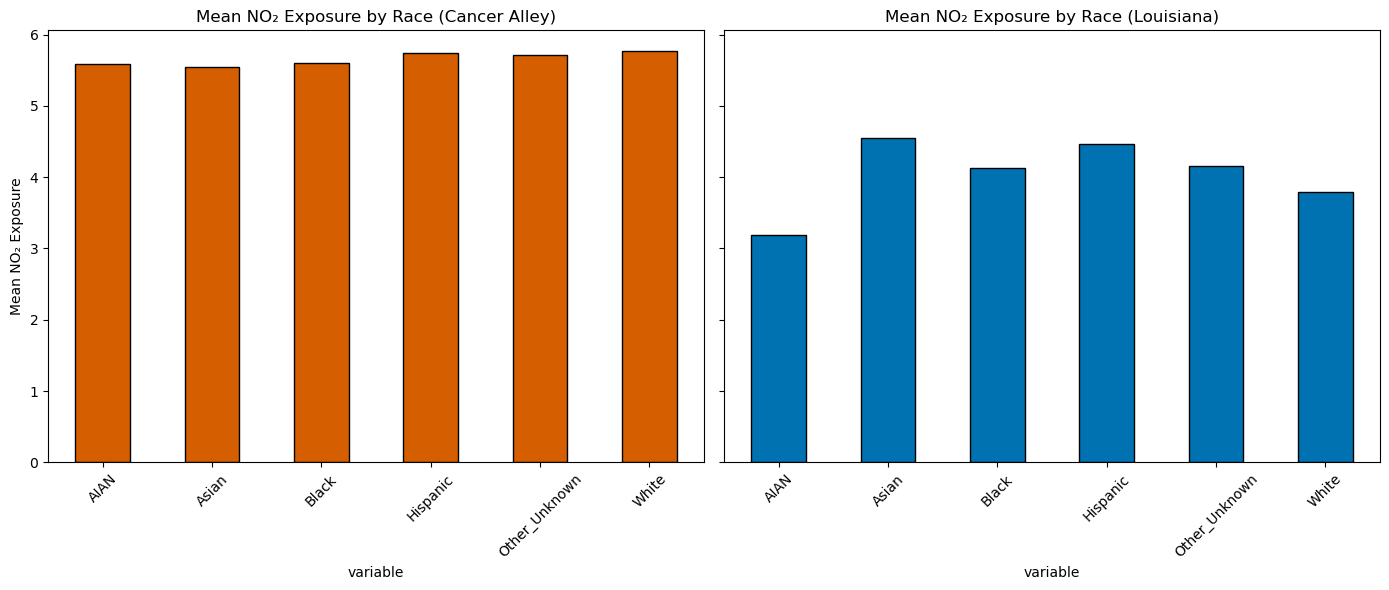

In [53]:
import xarray as xr
import matplotlib.pyplot as plt

def compute_weighted_mean_exposure(race_ds, no2_ds):
    race_weighted = race_ds * no2_ds["vertical_column_troposphere_tempo"]
    weighted_sum = race_weighted.sum(dim=["lat", "lon"])
    population_sum = race_ds.sum(dim=["lat", "lon"])
    mean_exposure = weighted_sum / population_sum
    
    # Extract DataArray if it's a Dataset with one variable
    if isinstance(mean_exposure, xr.Dataset):
        mean_exposure = mean_exposure.to_array().squeeze()
        
    # Convert to pandas Series sorted by race group
    return mean_exposure.to_series().sort_index()

# Compute mean exposure for Cancer Alley and Louisiana
mean_exposure_ca = compute_weighted_mean_exposure(race_ca, no2_ca)
mean_exposure_la = compute_weighted_mean_exposure(race_LA, no2_LA)

# Plot side-by-side bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

mean_exposure_ca.plot(
    kind='bar',
    ax=axes[0],
    color="#D55E00",
    edgecolor="black",
    title="Mean NO₂ Exposure by Race (Cancer Alley)"
)
axes[0].set_ylabel("Mean NO₂ Exposure")
axes[0].tick_params(axis='x', rotation=45)

mean_exposure_la.plot(
    kind='bar',
    ax=axes[1],
    color="#0072B2",
    edgecolor="black",
    title="Mean NO₂ Exposure by Race (Louisiana)"
)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


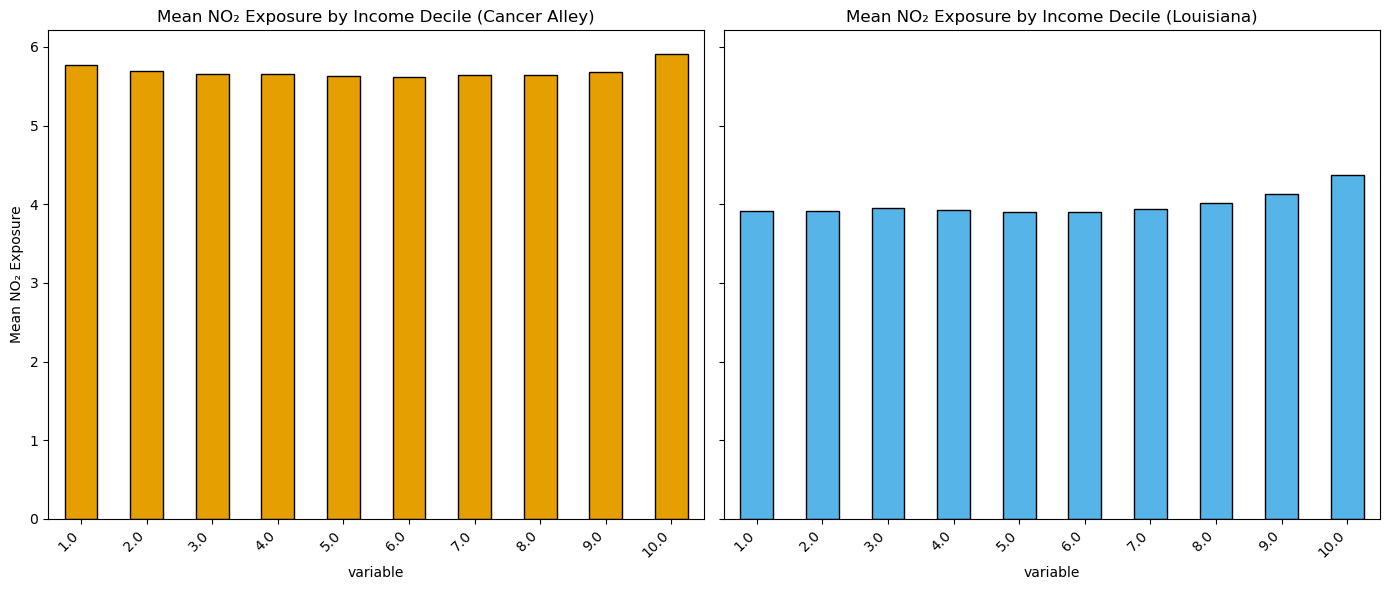

In [55]:
import xarray as xr
import matplotlib.pyplot as plt

def compute_weighted_mean_exposure_income(income_ds, no2_ds):
    # Compute weighted mean exposure
    income_weighted = income_ds * no2_ds["vertical_column_troposphere_tempo"]
    weighted_sum = income_weighted.sum(dim=["lat", "lon"])
    population_sum = income_ds.sum(dim=["lat", "lon"])
    mean_exposure = weighted_sum / population_sum
    
    if isinstance(mean_exposure, xr.Dataset):
        mean_exposure = mean_exposure.to_array().squeeze()
    
    # Convert to pandas Series and sort by numeric income level
    series = mean_exposure.to_series()
    series.index = series.index.astype(float)
    series = series.sort_index()
    return series

# Compute mean exposure for CA and LA
mean_exposure_income_ca = compute_weighted_mean_exposure_income(income_ca, no2_ca)
mean_exposure_income_la = compute_weighted_mean_exposure_income(income_LA, no2_LA)

# Plot side-by-side bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

mean_exposure_income_ca.plot(
    kind='bar',
    ax=axes[0],
    color="#E69F00",
    edgecolor="black",
    title="Mean NO₂ Exposure by Income Decile (Cancer Alley)"
)
axes[0].set_ylabel("Mean NO₂ Exposure")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticklabels(mean_exposure_income_ca.index.astype(str), rotation=45, ha="right")

mean_exposure_income_la.plot(
    kind='bar',
    ax=axes[1],
    color="#56B4E9",
    edgecolor="black",
    title="Mean NO₂ Exposure by Income Decile (Louisiana)"
)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xticklabels(mean_exposure_income_la.index.astype(str), rotation=45, ha="right")

plt.tight_layout()
plt.show()


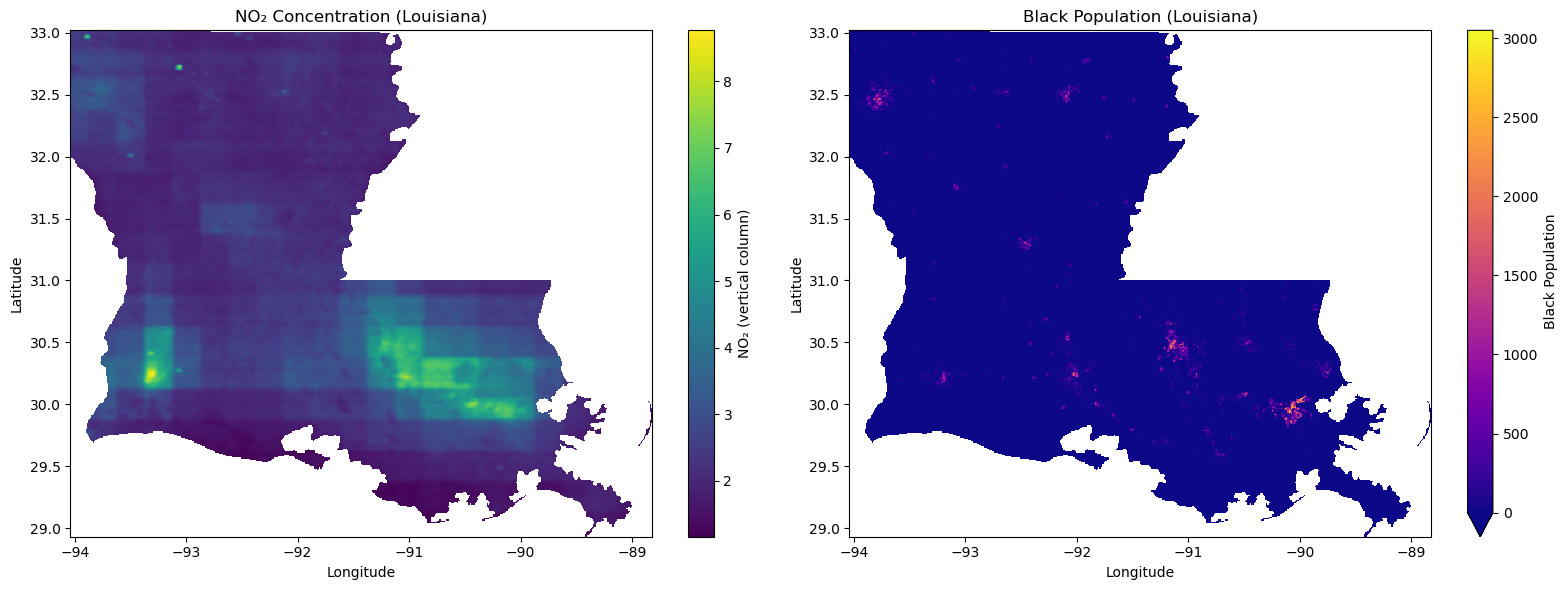

In [58]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Map 1: NO2 concentrations
no2_LA['vertical_column_troposphere_tempo'].plot(
    ax=axes[0],
    cmap='viridis',
    cbar_kwargs={'label': 'NO₂ (vertical column)'},
    rasterized=True
)
axes[0].set_title('NO₂ Concentration (Louisiana)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Map 2: Black race population
# Assuming 'Black' is a variable in race_LA Dataset
race_LA['Black'].plot(
    ax=axes[1],
    cmap='plasma',
    vmin=0,           # Set minimum color scale value to 0
    cbar_kwargs={'label': 'Black Population'},
    rasterized=True
)
axes[1].set_title('Black Population (Louisiana)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


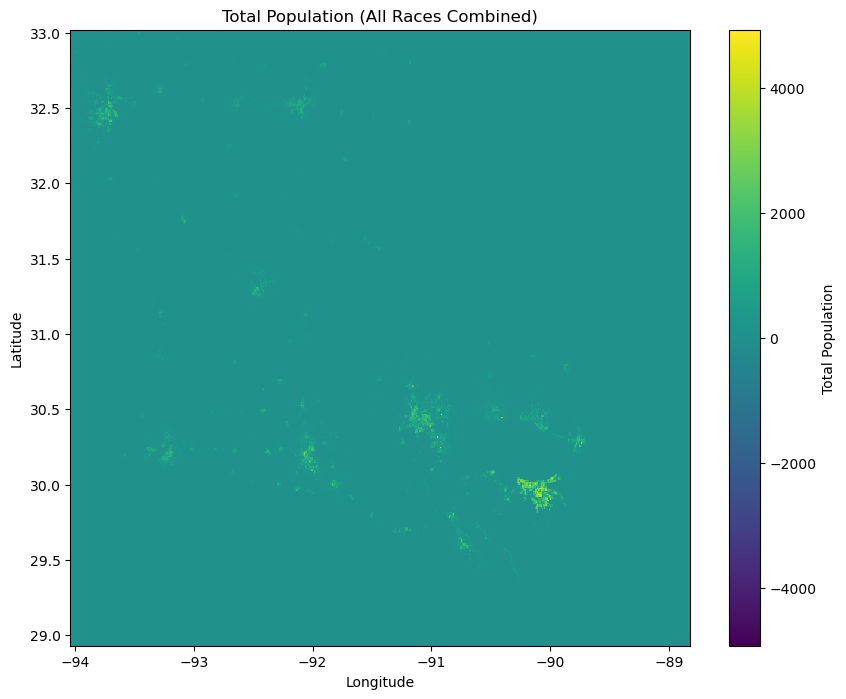

In [96]:
total_pop = race_LA.to_array().sum(dim='variable')

In [97]:
total_pop

<xarray.DataArray (lat: 409, lon: 522)> Size: 2MB
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  5., ...,  0.,  0.,  0.],
       [15.,  4., 29., ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float64 3kB 28.93 28.95 28.95 28.96 ... 32.99 33.01 33.02
  * lon      (lon) float64 4kB -94.03 -94.03 -94.02 ... -88.84 -88.83 -88.83

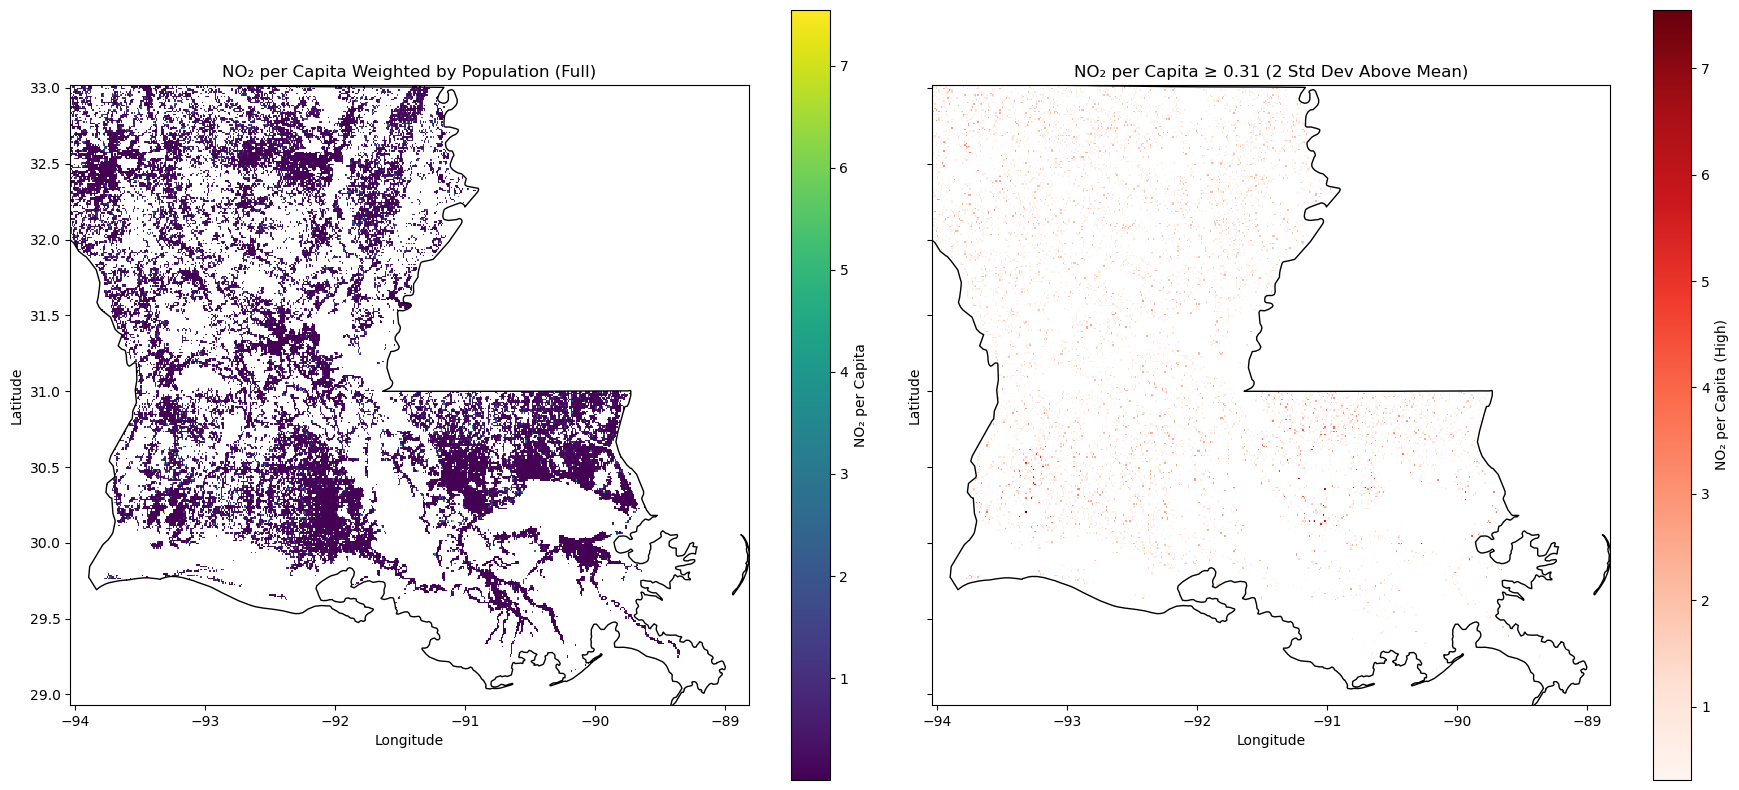

In [103]:
# Mask where population is valid (non-NaN and > 0)
valid_mask = (total_pop > 0) & (~total_pop.isnull())

# Apply the mask to both datasets
no2_valid = no2_LA["vertical_column_troposphere_tempo"].where(valid_mask)
pop_valid = total_pop.where(valid_mask)

# Compute NO₂ per capita (or per unit of population)
weighted_no2_pop = no2_valid / pop_valid

# Compute mean and standard deviation, ignoring NaNs
mean_weighted = weighted_no2_pop.mean(skipna=True)
std_weighted = weighted_no2_pop.std(skipna=True)
one_std_above = mean_weighted + 2 * std_weighted


import matplotlib.pyplot as plt
import geopandas as gpd

# Load Louisiana shapefile
la_outline = gpd.read_file("louisiana.geojson")

# Mask for high pollution areas
high_pollution = weighted_no2_pop.where(weighted_no2_pop >= mean_weighted)

fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

# Plot full weighted NO2 per capita
weighted_no2_pop.plot(
    ax=axs[0],
    x='lon',
    y='lat',
    cmap='viridis',
    cbar_kwargs={'label': 'NO₂ per Capita'},
)
la_outline.boundary.plot(ax=axs[0], edgecolor='black', linewidth=1)
axs[0].set_title("NO₂ per Capita Weighted by Population (Full)")

# Plot high pollution only
high_pollution.plot(
    ax=axs[1],
    x='lon',
    y='lat',
    cmap='Reds',
    vmin=mean_weighted.values,
    cbar_kwargs={'label': 'NO₂ per Capita (High)'},
)
la_outline.boundary.plot(ax=axs[1], edgecolor='black', linewidth=1)
axs[1].set_title(f"NO₂ per Capita ≥ {mean_weighted.values:.2f} (2 Std Dev Above Mean)")

for ax in axs:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()
